# HMS: Harmful Brain Activity Classification

***

**BMIN-GA3007 Deep Learning in Medicine**
**Final Project**

Keen Huei Liew (khl456) and Daria Chylak (duc9244)

# Setting up notebook
- Import Libraries 
- Configuration
- Utility functions

In [1]:
import gc
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import os
import pandas as pd
import random
import time
import timm
import sys
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GroupKFold
from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using 2 GPU(s)


In [2]:
class config:
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 32
    BATCH_SIZE_TEST = 32
    EPOCHS = 3
    FOLDS = 5
    MODEL = "tf_efficientnet_b0"
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    SEED = 20 
    VISUALIZE = True
    TEST_SIZE = 0.2
    
    
class paths:
    OUTPUT_DIR = "scratch/khl456/dlproject-hbac/working.log"
    CSV = "scratch/khl456/dlproject-hbac/dataset.csv"
    EEGS = "scratch/khl456/dlproject-hbac/eegs"
    SPECTROGRAMS = "scratch/khl456/dlproject-hbac/spectrograms"

In [3]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
 
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def plot_spectrogram(spectrogram_path: str):
    """
    Source: https://www.kaggle.com/code/mvvppp/hms-eda-and-domain-journey
    Visualize spectrogram recordings from a parquet file.
    :param spectrogram_path: path to the spectrogram parquet.
    """
    sample_spect = pd.read_parquet(spectrogram_path)
    
    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()
    label_interval = 5
    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        img = ax.imshow(np.log(split_spect[split_name]).T, cmap='viridis', aspect='auto', origin='lower')
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)')
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        ax.set_yticks(np.arange(len(split_spect[split_name].columns)))
        ax.set_yticklabels([column_name[3:] for column_name in split_spect[split_name].columns])
        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        ax.set_yticks(np.arange(0, len(split_spect[split_name].columns), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])
    plt.tight_layout()
    plt.show()
    
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)
    
label_to_num = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}
num_to_label = {v: k for k, v in label_to_num.items()}
LOGGER = get_logger()
seed_everything(config.SEED)

## Loading in data

In [4]:
# read in csv file
df = pd.read_csv(paths.CSV)
# print(df.head())
# drop unused columns
df = df.drop(columns=["seizure_vote","lpd_vote","gpd_vote","lrda_vote","grda_vote","other_vote"])
# display
label_col = df.columns[-1:]
df['target'] = df['expert_consensus'].map({'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5})
print(f"Dataframe shape is: {df.shape}")
print(f"Labels: {list(label_col)}")
print(df.head())

Dataframe shape is: (106800, 10)
Labels: ['expert_consensus']
       eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0  1628180742           0                       0.0          353733   
1  1628180742           1                       6.0          353733   
2  1628180742           2                       8.0          353733   
3  1628180742           3                      18.0          353733   
4  1628180742           4                      24.0          353733   

   spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                   0                               0.0   127492639   
1                   1                               6.0  3887563113   
2                   2                               8.0  1142670488   
3                   3                              18.0  2718991173   
4                   4                              24.0  3080632009   

   patient_id expert_consensus  target  
0       42516          Seizure       0  
1 

## Data pre-processing

Train and validate using only 1 crop per `eeg_id`. 

In [5]:
df_non = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_id':'first',
    'spectrogram_label_offset_seconds':'min'
})
df_non.columns = ['spectrogram_id','min']

aux = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg({
    'spectrogram_label_offset_seconds':'max'
})
df_non['max'] = aux

aux = df.groupby('eeg_id')[['patient_id']].agg('first')
df_non['patient_id'] = aux

aux = df.groupby('eeg_id')[['expert_consensus']].agg('first')
df_non['expert_consensus'] = aux

aux = df.groupby('eeg_id')[['target']].agg('first')
df_non['target'] = aux

# split into train and test sets
train_df_non, test_df_non = train_test_split(df_non, test_size=config.TEST_SIZE, random_state=config.SEED)

train_df_non = train_df_non.reset_index()
print('Train non-overlap eeg_id shape:', train_df_non.shape )
train_df_non.head()

Train non-overlap eeg_id shape: (13671, 7)


,eeg_id,spectrogram_id,min,max,patient_id,expert_consensus,target
0,2875333847,1110815357,0.0,8.0,30631,Other,5
1,1880708293,1191083537,412.0,424.0,51260,LPD,1
2,82952885,262253829,0.0,28.0,16900,GPD,2
3,4170553511,978225174,0.0,0.0,43224,Seizure,0
4,2482901265,701519913,0.0,16.0,27228,LPD,1


## Reading in Spectrograms

- `all_spectograms` dictionary contains `spectogram_id` as keys (`int` keys) 
- Values are the spectogram sequences (as 2-dimensional `np.array`) of shape `(timesteps, 400)`

There are 11138 spectrogram parquets


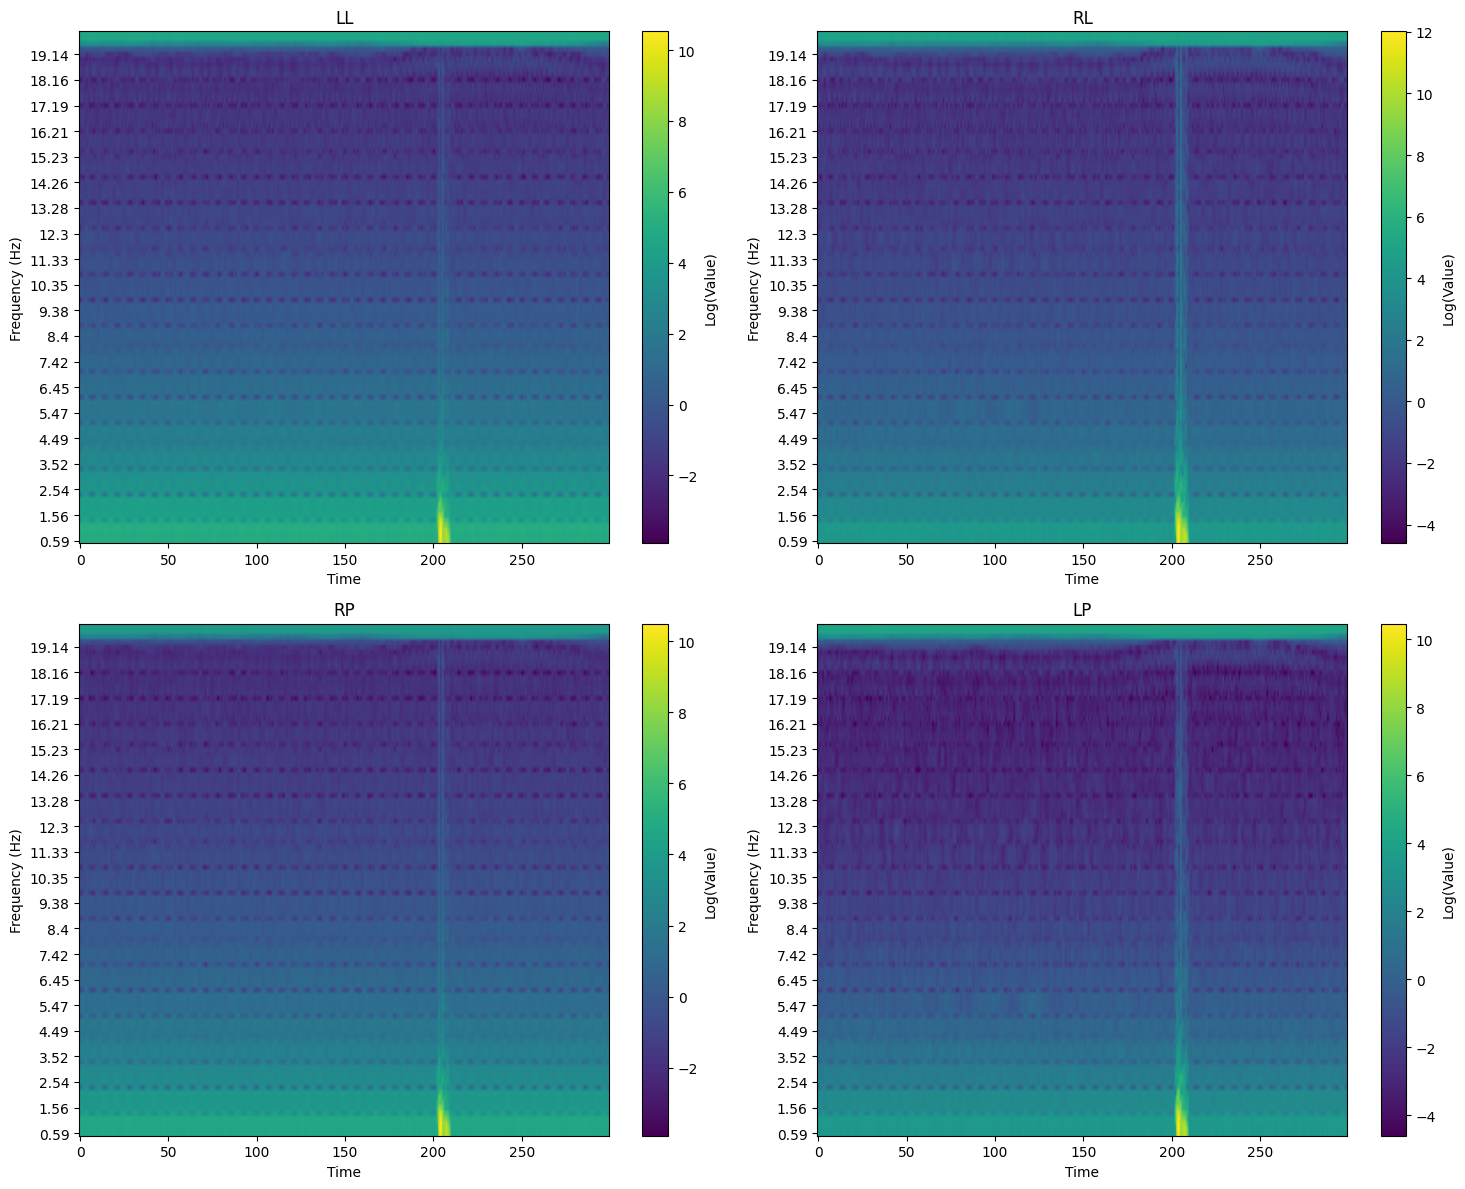

CPU times: user 5.94 s, sys: 6.4 s, total: 12.3 s
Wall time: 1min 3s


In [6]:
%%time

paths_spectrograms = glob(paths.SPECTROGRAMS + "*.parquet")
print(f'There are {len(paths_spectrograms)} spectrogram parquets')

all_spectrograms = {}
    for file_path in tqdm(paths_spectrograms):
        aux = pd.read_parquet(file_path)
        name = int(file_path.split("/")[-1].split('.')[0])
        all_spectrograms[name] = aux.iloc[:,1:].values
        del aux
    
if config.VISUALIZE:
    idx = np.random.randint(0,len(paths_spectrograms))
    spectrogram_path = paths_spectrograms[idx]
    plot_spectrogram(spectrogram_path)

## Reading in EEGs

- `all_eegs` dictionary contains `eeg_id` as keys (`int` keys)
- Values are the eeg sequences (as 3-dimensional `np.array`) of shape `(128, 256, 4)`.



In [7]:
%%time

paths_eegs = glob(paths.EEGS + "*.parquet")
print(f'There are {len(paths_eegs)} EEG parquets')

all_eegs = {}
    for file_path in tqdm(paths_eegs):
        aux = pd.read_parquet(file_path)
        name = int(file_path.split("/")[-1].split('.')[0])
        all_eegs[name] = aux.iloc[:,1:].values
        del aux

There are 17089 EEG spectrograms
CPU times: user 4.28 s, sys: 8.21 s, total: 12.5 s
Wall time: 52.2 s


# CustomDataset and DataLoader

Create a custom `Dataset` to load data.

Outputs both Kaggle spectrograms and EEG spectrograms as 8 channel image of size `(128, 256, 8)`

[1]: https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43/comments#2617811

In [16]:
class CustomDataset(Dataset):
    def __init__(
        self, train_df: pd.DataFrame, config,
        augment: bool = False, mode: str = 'train',
        specs: Dict[int, np.ndarray] = all_spectrograms,
        eeg_specs: Dict[int, np.ndarray] = all_eegs
    ): 
        self.train_df = train_df
        self.config = config
        self.batch_size = self.config.BATCH_SIZE_TRAIN
        self.augment = augment
        self.mode = mode
        self.spectrograms = all_spectrograms
        self.eeg_spectrograms = eeg_specs
        
    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.train_df)
        
    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X, y = self.__data_generation(index)
        if self.augment:
            X = self.__transform(X) 
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.int64)
                        
    def __data_generation(self, index):
        """
        Generates data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        img = np.ones((128,256), dtype='float32')
        row = self.train_df.iloc[index]
        if self.mode=='test': 
            r = int((row['min'] + row['max']) // 4)
            y = row['target']
        else: 
            r = 0  
            y = -1
            
        for region in range(4):
            img = self.spectrograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectrogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
        
        if 'eeg_id' in self.eeg_spectrograms:
            img = self.eeg_spectrograms[row['eeg_id']]
            X[:, :, 4:] = img
            
        return X, y
    
    def __transform(self, img):
        transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
        ])
        return transforms(image=img)['image']

### Visualize dataloader spectrogram images

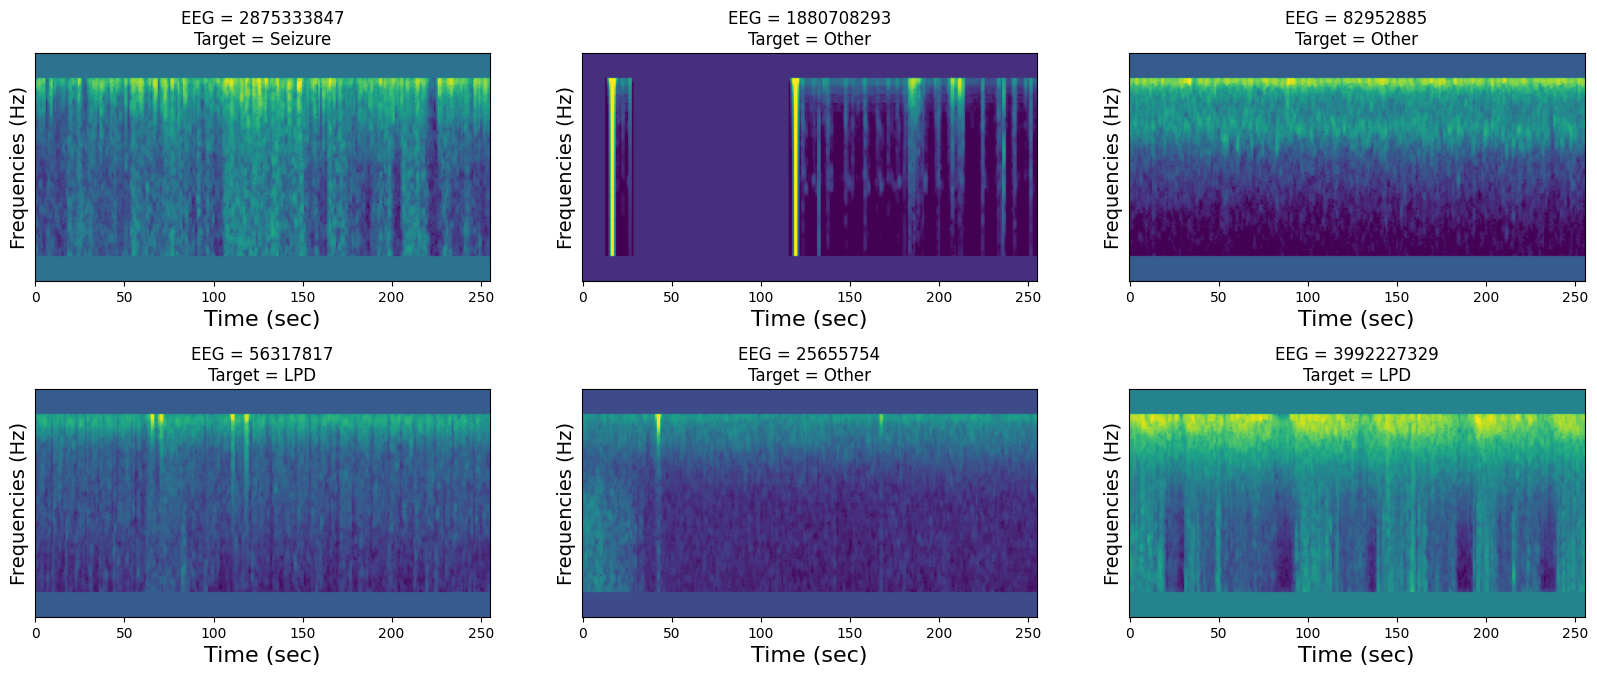

In [9]:
from sklearn.model_selection import KFold, GroupKFold

gkf = GroupKFold(n_splits=config.FOLDS)
for fold, (train_index, valid_index) in enumerate(gkf.split(train_df_non, train_df_non.target, train_df_non.patient_id)):
    train_data = train_df_non.iloc[train_index]
    val_data = train_df_non.iloc[valid_index]

    train_dataset = CustomDataset(train_data, config, mode="train")
    valid_dataset = CustomDataset(val_data, config, mode="train")
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE_TRAIN,
        shuffle=True,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.BATCH_SIZE_VALID,
        shuffle=False,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
    )

if config.VISUALIZE:
    ROWS = 2
    COLS = 3
    for (X, y) in train_loader:
        plt.figure(figsize=(20,8))
        for row in range(ROWS):
            for col in range(COLS):
                plt.subplot(ROWS, COLS, row*COLS + col+1)
                img = X[row*COLS + col, :, :, 0]
                mn = img.flatten().min()
                mx = img.flatten().max()
                img = (img-mn)/(mx-mn)
                plt.imshow(img)
                eeg = train_df_non.eeg_id.values[row*config.BATCH_SIZE_TRAIN + row*COLS + col]
                t = num_to_label[y[row * COLS + col].item()]
                plt.title(f'EEG = {eeg}\nTarget = {t}',size=12)
                plt.yticks([])
                plt.ylabel('Frequencies (Hz)',size=14)
                plt.xlabel('Time (sec)',size=16)
        plt.show()
        break

# EfficientNetB0 Model

***

We used the [timm](https://github.com/huggingface/pytorch-image-models) library for our models.

Our models receives spectrograms from our data loader, which we reshape to suit EfficientNet's expected input shape (3-channel to mimic RGB)

In [10]:
class CustomModel(nn.Module):
    def __init__(self, config, num_classes=6, pretrained=True):
        super(CustomModel, self).__init__()
        self.config = config
        self.model = timm.create_model(config.MODEL, pretrained=pretrained, num_classes=0, in_chans=3)
        self.classifier = nn.Linear(self.model.num_features, num_classes)
        
    def __reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # Get the spectrograms and EEGs and reshape them appropriately
        spectrograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectrograms = torch.cat(spectrograms, dim=1)
        
        eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # Extend to three channel inputs by repeating the matrix across channels
        x = spectrograms
        x = torch.cat([x, x, x], dim=3) 
        x = x.permute(0, 3, 1, 2) 
        return x

    def forward(self, x):
        x = self.__reshape_input(x)
        features = self.model(x)
        output = self.classifier(features)
        return output

# Main Training Loop

- We trained using GroupKFold on `patient_id`.
- We used `ReduceLROnPlateau`, `CrossEntropyLoss`, and `AdamW` as our scheduler, criterion, and optimizer respectively.

In [11]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import GroupKFold
import numpy as np

# Prepare and split the data using GroupKFold
gkf = GroupKFold(n_splits=config.FOLDS)
results = []

# Iterate over each fold
for fold, (train_index, valid_index) in enumerate(gkf.split(train_df_non, groups=train_df_non['patient_id'])):
    print(f"Training fold {fold+1}/{config.FOLDS}")
    
    # Split data into training and validation sets
    train_data = train_df_non.iloc[train_index]
    val_data = train_df_non.iloc[valid_index]

    # Create datasets for training and validation
    train_dataset = CustomDataset(train_data, config, mode="train")
    valid_dataset = CustomDataset(val_data, config, mode="train")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE_TRAIN,
        shuffle=True,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=config.BATCH_SIZE_VALID,
        shuffle=False,
        num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
    )
    
    # Initialize model, optimizer, and scheduler for each fold to avoid leakage
    model = CustomModel(config).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, min_lr=1e-6)
    
    # Training and validation for the current fold
    for epoch in range(config.EPOCHS):
        LOGGER.info(f"Epoch {epoch+1}/{config.EPOCHS}, Fold {fold+1}")
        
        # Training phase
        model.train()
        train_loss = 0
        correct_predictions = 0
        total_predictions = 0
        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)
            total_predictions += labels.size(0)

        train_loss /= len(train_loader.dataset)
        train_accuracy = correct_predictions.double() / total_predictions
        LOGGER.info(f"Training Loss: {train_loss:.4f}")
        LOGGER.info(f"Training Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        validation_loss = 0
        correct_predictions = 0
        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc="Validation", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels.data)

        validation_loss /= len(valid_loader.dataset)
        validation_accuracy = correct_predictions.double() / len(valid_loader.dataset)
        LOGGER.info(f"Validation Loss: {validation_loss:.4f}")
        LOGGER.info(f"Validation Accuracy: {validation_accuracy:.4f}")
        
        # Scheduler step
        scheduler.step(validation_loss)
    
    # Store results for each fold
    results.append({
        'fold': fold,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'validation_loss': validation_loss,
        'validation_accuracy': validation_accuracy
    })

# Print results from all folds
for result in results:
    print(f"Fold {result['fold']+1}: Train Loss={result['train_loss']:.4f}, Train Accuracy={result['train_accuracy']:.4%}, Validation Loss={result['validation_loss']:.4f}, Validation Accuracy={result['validation_accuracy']:.4%}")


Training fold 1/5


Epoch 1/3, Fold 1
Training Loss: 1.0534                                      
Training Accuracy: 0.6221
Validation Loss: 1.0194                                    
Validation Accuracy: 0.6355
Epoch 2/3, Fold 1
Training Loss: 0.7323                                      
Training Accuracy: 0.7366
Validation Loss: 0.9856                                    
Validation Accuracy: 0.6680
Epoch 3/3, Fold 1
Training Loss: 0.5689                                      
Training Accuracy: 0.7968
Validation Loss: 1.0912                                    
Validation Accuracy: 0.6358


Training fold 2/5


Epoch 1/3, Fold 2
Training Loss: 1.0414                                      
Training Accuracy: 0.6244
Validation Loss: 0.9525                                    
Validation Accuracy: 0.6474
Epoch 2/3, Fold 2
Training Loss: 0.7302                                      
Training Accuracy: 0.7422
Validation Loss: 0.9530                                    
Validation Accuracy: 0.6375
Epoch 3/3, Fold 2
Training Loss: 0.5731                                      
Training Accuracy: 0.7970
Validation Loss: 1.0166                                    
Validation Accuracy: 0.6474


Training fold 3/5


Epoch 1/3, Fold 3
Training Loss: 1.0541                                      
Training Accuracy: 0.6212
Validation Loss: 0.9833                                    
Validation Accuracy: 0.6631
Epoch 2/3, Fold 3
Training Loss: 0.7256                                      
Training Accuracy: 0.7396
Validation Loss: 0.9270                                    
Validation Accuracy: 0.6628
Epoch 3/3, Fold 3
Training Loss: 0.5724                                      
Training Accuracy: 0.7952
Validation Loss: 1.0279                                    
Validation Accuracy: 0.6617


Training fold 4/5


Epoch 1/3, Fold 4
Training Loss: 1.0337                                      
Training Accuracy: 0.6324
Validation Loss: 0.9859                                    
Validation Accuracy: 0.6350
Epoch 2/3, Fold 4
Training Loss: 0.7188                                      
Training Accuracy: 0.7408
Validation Loss: 0.9539                                    
Validation Accuracy: 0.6463
Epoch 3/3, Fold 4
Training Loss: 0.5778                                      
Training Accuracy: 0.7922
Validation Loss: 1.0453                                    
Validation Accuracy: 0.6258


Training fold 5/5


Epoch 1/3, Fold 5
Training Loss: 1.0454                                      
Training Accuracy: 0.6168
Validation Loss: 0.9285                                    
Validation Accuracy: 0.6587
Epoch 2/3, Fold 5
Training Loss: 0.7327                                      
Training Accuracy: 0.7340
Validation Loss: 0.8964                                    
Validation Accuracy: 0.6708
Epoch 3/3, Fold 5
Training Loss: 0.5766                                      
Training Accuracy: 0.7944
Validation Loss: 0.9518                                    
Validation Accuracy: 0.6741


Fold 1: Train Loss=0.5689, Train Accuracy=79.6829%, Validation Loss=1.0912, Validation Accuracy=63.5832%
Fold 2: Train Loss=0.5731, Train Accuracy=79.7012%, Validation Loss=1.0166, Validation Accuracy=64.7403%
Fold 3: Train Loss=0.5724, Train Accuracy=79.5180%, Validation Loss=1.0279, Validation Accuracy=66.1668%
Fold 4: Train Loss=0.5778, Train Accuracy=79.2247%, Validation Loss=1.0453, Validation Accuracy=62.5823%
Fold 5: Train Loss=0.5766, Train Accuracy=79.4446%, Validation Loss=0.9518, Validation Accuracy=67.4104%


## Plotting accuracy and loss curves

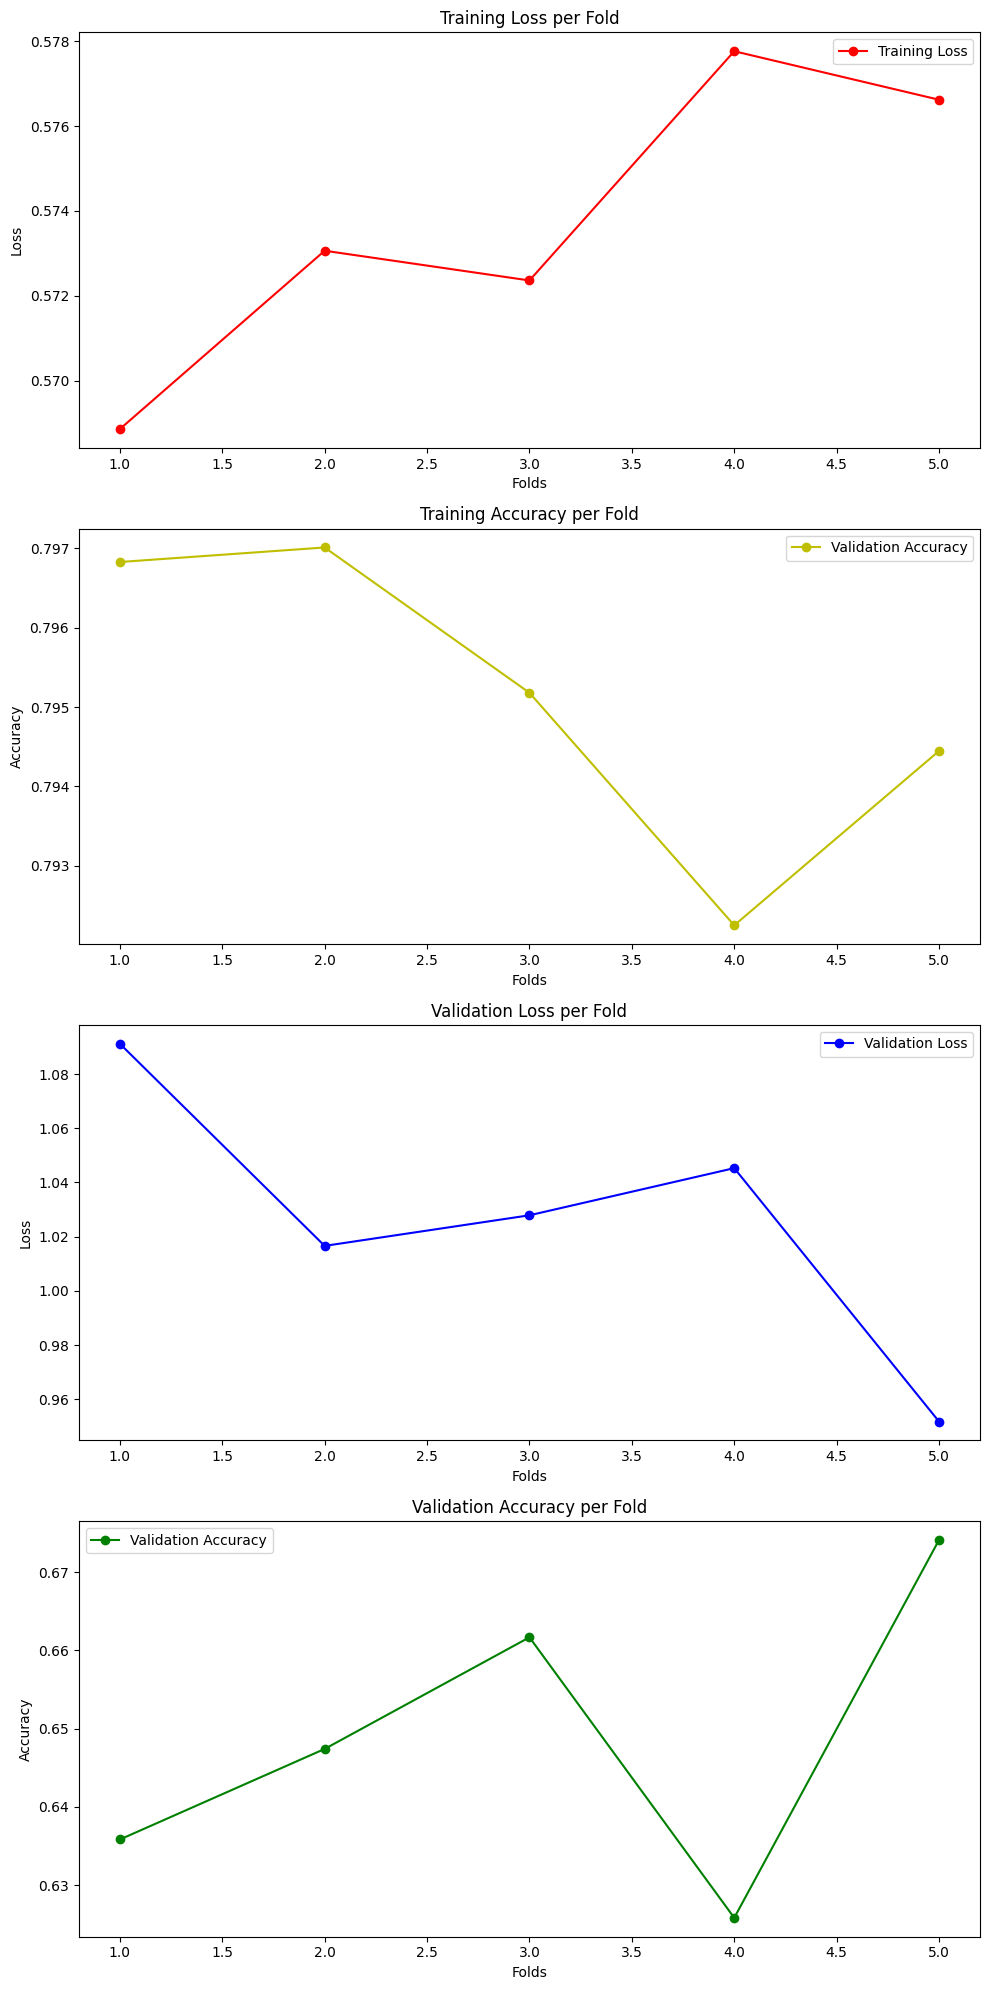

In [12]:
train_losses = [result['train_loss'] for result in results]
train_accuracies = [result['train_accuracy'].cpu().numpy() for result in results]
validation_losses = [result['validation_loss'] for result in results]
validation_accuracies = [result['validation_accuracy'].cpu().numpy() for result in results]

folds = [result['fold'] + 1 for result in results]  # Fold count starts from 1 for plotting

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Plot training loss
axs[0].plot(folds, train_losses, 'o-', color="r",
            label="Training Loss")
axs[0].set_title("Training Loss per Fold")
axs[0].set_xlabel("Folds")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="best")

# Plot training accuracy
axs[1].plot(folds, train_accuracies, 'o-', color="y",
            label="Validation Accuracy")
axs[1].set_title("Training Accuracy per Fold")
axs[1].set_xlabel("Folds")
axs[1].set_ylabel("Accuracy")
axs[1].legend(loc="best")

# Plot validation loss
axs[2].plot(folds, validation_losses, 'o-', color="b",
            label="Validation Loss")
axs[2].set_title("Validation Loss per Fold")
axs[2].set_xlabel("Folds")
axs[2].set_ylabel("Loss")
axs[2].legend(loc="best")

# Plot validation accuracy
axs[3].plot(folds, validation_accuracies, 'o-', color="g",
            label="Validation Accuracy")
axs[3].set_title("Validation Accuracy per Fold")
axs[3].set_xlabel("Folds")
axs[3].set_ylabel("Accuracy")
axs[3].legend(loc="best")

# Show plot
plt.tight_layout()
plt.show()

# Model Evaluation

In [17]:
#create test dataloader
test_dataset = CustomDataset(test_df_non, config, mode="test")
test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE_TEST,
    shuffle=False,
    num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True
)

Accuracy: 0.4847
Precision: 0.7490
Recall: 0.2412
F1 Score: 0.2279


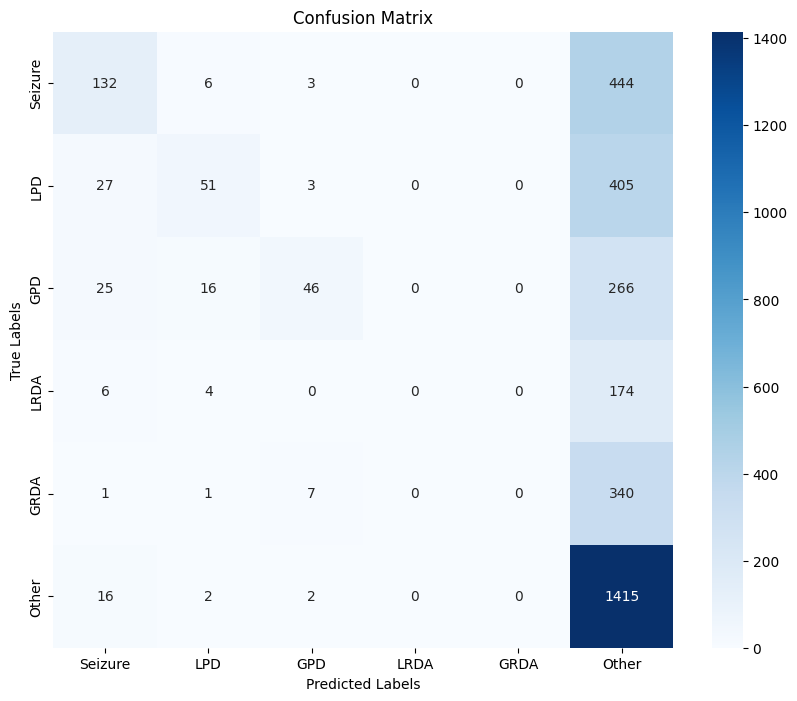

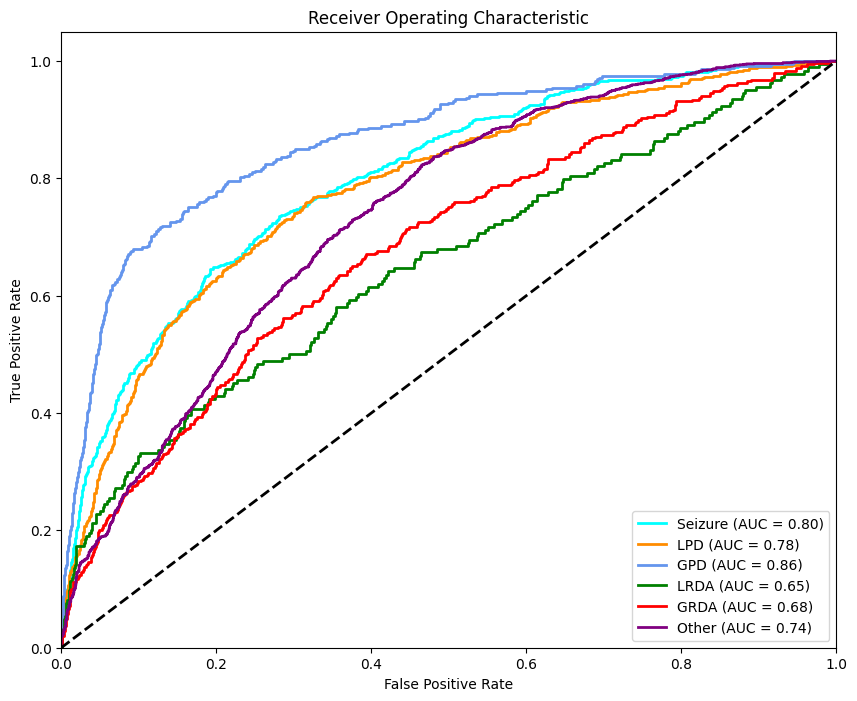

In [20]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, RocCurveDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle

def evaluate_model(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())  
            all_labels.append(labels.cpu().numpy()) 
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)
    return all_probs, all_labels

probs, true_labels = evaluate_model(model, test_loader, device)

# Metrics computation
pred_labels = np.argmax(probs, axis=1)
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='macro', zero_division=1)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_num.keys(), yticklabels=label_to_num.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
y_bin = label_binarize(true_labels, classes=np.unique(true_labels))
n_classes = y_bin.shape[1]

num_to_label = {v: k for k, v in label_to_num.items()}

fpr = dict()
tpr = dict()
roc_auc = dict()
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'{num_to_label[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
